Alright onto more helio-relevant problems.  Let's consider eigenmodes in rotating Rayleigh-Benard.  This system can be written as

$$
\partial_t \vec{u} + \nabla p + \hat{e}_z\times \vec{u} - Ro_c T \hat{e}_r  - Ek \nabla^2 \vec{u} = 0,\\
\nabla\cdot\vec{u} = 0,\\
\partial_t T + u_r \partial_r\overline{T} - \frac{Ek}{Pr}\nabla^2 T = 0,
$$

where $Ek$ is the Ekman number defined here as $\nu/(2\Omega_0 (r_o-r_i)^2)$, with $\nu$ the kinematic viscosity, $\Omega_0$ the bulk rotation rate, and $r_o$ the radius of the outer bounding sphere and $r_i$ the inner sphere radius.  The convective Rossby number $Ro_c = Ra Ek^2/Pr$ Likewise, $\vec{u}$ is the velocity, $p$ a gauge field, and $T$ the temperature perturbation. Turning this into an eigenproblem, we assume oscillatory modes such that $\vec{u} = \overline{u} e^{-i\omega t}$, more generally there can be non-normal behavior such that $\vec{u} = \overline{u} g(t)$ for some hopefully bounded $g(t)$. To assess that we can use pseudospectra, but I'll save that for another time.

The background temperature is

$$
\overline{T} = T_i \left[1 - \frac{r-r_b}{\left(r_o-r_i\right)} \left(1+\tanh{S\frac{r-r_b}{r_o-r_i}}\right)\right],
$$

where $a$ is the interface stiffness between an isothermal layer and a convectively unstable region, and with $r_b$ being the radius of the transition.

In [1]:
#Let's get ourselves started with a few module imports.
import os
import numpy as np
import dedalus.public as d3
from dedalus.core import evaluator #currently necessary, will be obsolete soon.

2023-03-03 23:16:46,124 dedalus 0/1 WARNING :: Threading has not been disabled. This may massively degrade Dedalus performance.
2023-03-03 23:16:46,125 dedalus 0/1 WARNING :: We strongly suggest setting the "OMP_NUM_THREADS" environment variable to "1".
2023-03-03 23:16:46,390 numexpr.utils 0/1 INFO :: NumExpr defaulting to 8 threads.


In [2]:
#Datatype
dtype = np.complex128

#Problem Parameters
nphi=4 #We are going to look at axisymmetric waves here.
ntheta=32 #Number of grid points in latitude (Legendre weights)
nr=32 #Number of grid points in radius (Chebyshev weights)
target_m = 1 #Selected mode

ri = 0.001     #Inner radius
ro = 1.00    #Outer radius
rb = 0.7     #Base of CZ
S = 20       #Stiffness of transition
Ek = 1e-3    #Ekman number
Pr = 1e0     #Prandtl number

#Convective Rossby number
Ro_c = 0.3

#Get Ra from Ro_c
Ra = Pr*Ro_c/Ek**2    #Rayleigh number
print('Ra=',Ra)
# Set up output directory for eigenmodes
label='0'
data_dir = 'RB_Waves_Ra{:.2f}_Ek{:.2f}'.format(np.log10(Ra),np.log10(Ek))+'_'+label

#Define radii for coordinate system creators
radii = (ri,ro)

Ra= 300000.0


In [3]:
#For eigenproblems there's no MPI mesh for dedalus, but there can be for SLEPc.
mesh = None
# Bases
coords = d3.SphericalCoordinates('phi', 'theta', 'r') #Define the spherical coordinate names
dist = d3.Distributor(coords, mesh=mesh, dtype=dtype) #Set up the internal communicators and initialize.
#Define a shell basis (so Tensor spherical harmonics and a Chebyshev radial basis)
shell = d3.ShellBasis(coords, shape=(nphi,ntheta,nr), radii=radii, dtype=dtype)
sphere = shell.outer_surface #Define the bounding sphere coordinate systems (e.g. S_2)
phi, theta, r = dist.local_grids(shell) #Get local coordinate arrays

In [4]:
# Fields over the shell
u = dist.VectorField(coords, bases=shell, name='u') #Vector velocity field
p = dist.Field(bases=shell, name='p') #Gauge field.
T = dist.Field(bases=shell, name='T') #Temperature field.
T0 = dist.Field(bases=shell.meridional_basis, name='T') #Temperature field.
grad_T0 = dist.Field(bases=shell.meridional_basis, name='T') #Temperature field.

z = (r-rb)/(ro-ri)
tnh = np.tanh(S*z)
T0['g'] = 1-z*(1+tnh)*(ro-ri)/(ro-rb)/2
sch2 = 1-tnh**2
grad_T0['g'] = -(1 + tnh + z*S*sch2)/(ro-rb)/2

# Eigenvalue
omega = dist.Field(name='omega')

In [5]:
#Tau boundary mullifiers (dummy variables permitting the
# our spectral representation of boundary conditions)
tau_u_ri = dist.VectorField(coords, bases=sphere, name='tau_u_ri')
tau_u_ro = dist.VectorField(coords,bases=sphere, name='tau_u_ro')
tau_p = dist.Field(name='tau_p')

tau_T_ri = dist.Field(bases=sphere)
tau_T_ro = dist.Field(bases=sphere)

In [6]:
#Substitutions

dt = lambda A: -1j*omega*A #Our eigenvalue operator.

#Here we lift the taus onto the shell derivative basis 
#(So ChebyU in radius and the shifted Jacobi polynomials in latitude)
lift_basis = shell.derivative_basis(1) # First derivative basis
lift = lambda A: d3.Lift(A, lift_basis, -1)

In [7]:
#First order formulation
rvec = dist.VectorField(coords, bases=shell.meridional_basis, name='rvec')
#Radial component, since chebyshev in radius
rvec['g'][2] = r

#Define the gradient tensor and the first lift for the lower boundary
grad_u = d3.grad(u) + rvec*lift(tau_u_ri)
grad_T = d3.grad(T) + rvec*lift(tau_T_ri)

#For stress-free boundary conditions
strain_rate = d3.grad(u) + d3.transpose(d3.grad(u))

#Vertical unit vector in spherical coordinates
#This guy is special: it is defined over a meridional basis 
# (e.g. coupled in radius and theta, but not in phi).
#This restricted basis is called the meridional_basis.
ez = dist.VectorField(coords, bases=shell.meridional_basis, name='ez')
#Theta component
ez['g'][1] = -np.sin(theta)
#Radial component
ez['g'][2] = np.cos(theta)

er = dist.VectorField(coords, bases=shell.meridional_basis, name='er')
#Radial component
er['g'][2] = 1

kappa = Ek/Pr
nu = Ek
B = Ra*Ek**2/Pr
print('B=',B,'Ro_c=',Ro_c)

B= 0.3 Ro_c= 0.3


In [8]:
# Problem
problem = d3.EVP([T, p, u, tau_T_ri, tau_T_ro, tau_u_ri, tau_u_ro, tau_p], eigenvalue=omega, namespace=locals())

#Equations of motion
#Continuity + a tau to control the gauge field.
problem.add_equation("trace(grad_u) + tau_p = 0")
#Momentum equation with the Coriolis force.
problem.add_equation("dt(u) + grad(p) + cross(ez,u) - nu*div(grad_u) - B*T*er + lift(tau_u_ro) = 0")
#Temperature equation
problem.add_equation("dt(T) - dot(er*grad_T0,u) - kappa*div(grad_T) + lift(tau_T_ro) = 0")

{'LHS': Add(Add(Convert(Add(Mul(Mul((-0-1j), <Field 139901408952592>), <Field 139901406864912>), Mul(-1, Dot(Mul(<Field 139901406890832>, <Field 139901406953680>), <Field 139901406859536>)))), Mul(-1, Mul(0.001, Div(Add(Grad(<Field 139901406864912>), Mul(<Field 139901407018832>, Lift(<Field 139901406898448>))))))), Convert(Lift(<Field 139901406896784>))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': dtype('complex128'),
 'M': Convert(Mul((-0-1j), <Field 139901406864912>)),
 'L': Add(Add(Convert(Mul(-1, Dot(Mul(<Field 139901406890832>, <Field 139901406953680>), <Field 139901406859536>))), Mul(-1, Mul(0.001, Div(Add(Grad(<Field 139901406864912>), Mul(<Field 139901407018832>, Lift(<Field 139901406898448>))))))), Convert(Lift(<Field 139901406896784>))),
 'domain': <dedalus.core.domain.Domain at 0x7f3d55adb590>,
 'matrix_dependence': array([False,  True,  True]),
 'matrix_coupling': array([False,  True,  True])}

In [9]:
# Pressure Gauge
problem.add_equation("integ(p) = 0")

#Boundary conditions
stress_free=True
if (stress_free):
    problem.add_equation("radial(u(r=ri)) = 0") #Impenetrable lower boundary
    problem.add_equation("angular(radial(strain_rate(r=ri),0),0) = 0") #Stress-free lower boundary
    problem.add_equation("radial(u(r=ro)) = 0") #Impenetrable upper boundary
    problem.add_equation("angular(radial(strain_rate(r=ro),0),0) = 0") #Stress-free upper boundary
else:
    problem.add_equation("u(r=ri)=0") #No-slip boundaries
    problem.add_equation("u(r=ro)=0")
    
problem.add_equation("T(r=ri) = 0")
problem.add_equation("T(r=ro) = 0")

{'LHS': interp(<Field 139901406864912>, r=1.0),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.complex128,
 'M': 0,
 'L': interp(<Field 139901406864912>, r=1.0),
 'domain': <dedalus.core.domain.Domain at 0x7f3d55c84e90>,
 'matrix_dependence': array([False,  True,  True]),
 'matrix_coupling': array([False, False,  True])}

In [10]:
solver = problem.build_solver()
subproblem = solver.subproblems_by_group[(target_m, None, None)]
ss = subproblem.subsystems[0]

#Let's use the sparse solver (waaaaay faster).
dense=False

#Let's ask for 128 eigenvalues
neig = 128

#Let's set a target for low frequency modes
guess = 0.01e0*1j+0.5

if (dense):
    solver.solve_dense(subproblem)
else:
    solver.solve_sparse(subproblem, neig, guess)


2023-03-03 23:17:10,227 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 23s, Remaining: 0s, Rate: 4.3e-02/s


In [11]:
namespace = {}
solver.evaluator = evaluator.Evaluator(solver.dist, namespace)

if not os.path.exists('{:s}'.format(data_dir)):
    os.mkdir('{:s}'.format(data_dir))

np.save(data_dir+'/eigenvalues.npy',solver.eigenvalues)
path = data_dir + '/checkpoints'
checkpoint = solver.evaluator.add_file_handler(path, max_writes=1)
checkpoint.add_tasks(solver.state)

for i in range(neig):
    solver.set_state(i, ss)
    solver.evaluator.evaluate_handlers([checkpoint],sim_time=1,wall_time=1,timestep=1,iteration=1)

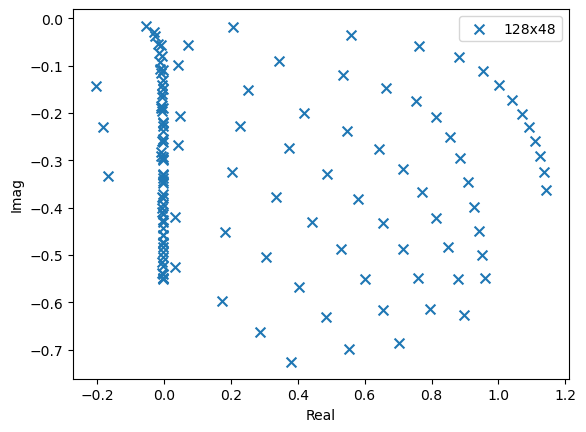

In [12]:
import matplotlib.pyplot as plt

fig,ax=plt.subplots()

exists  = os.path.isdir(data_dir)
if (exists):
    eigs = np.load(data_dir+'/eigenvalues.npy')
    ax.scatter(eigs.real,eigs.imag,label='128x48',marker='x',alpha=1,s=50)

ax.set_xlabel('Real')
ax.set_ylabel('Imag')
ax.legend()
fig.savefig('Eigs_RB_Ra{:.2f}_Ek{:.2f}'.format(np.log10(Ra),np.log10(Ek))+'.png', dpi=600)

Let's see what some of these modes look like!

[-0.02748245-0.0370541j   0.56038407-0.03590076j -0.02934396-0.02783913j
  0.20530428-0.01875507j -0.05470242-0.01603852j] [42  0 40  7 44]
(-0.10956843319302056+0.03757224303683938j) (0.10956843319302056-0.03757224303683938j)
(128, 48)
-0.1923587686628353 0.1923587686628353
(128, 48)
-0.5378496228087081 0.5378496228087081
(128, 48)
-0.22315351493190452 0.22315351493190452
(128, 48)
-0.08026633984320036 0.08026633984320036
(128, 48)
-0.47099547746085657 0.47099547746085657


/tmp/ipykernel_51800/3835239476.py:64: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=0.0,right=1.0)


(-0.06376793423415168+0.008968321951548201j) (0.06376793423415168-0.008968321951548201j)
(128, 48)
-0.21989641695571865 0.21989641695571865
(128, 48)
-0.32076018403555345 0.32076018403555345
(128, 48)
-0.07402606189504812 0.07402606189504812
(128, 48)
-0.032162635965839605 0.032162635965839605
(128, 48)
-0.37636503618587386 0.37636503618587386
(-0.09413228519090663+0.02504948844224357j) (0.09413228519090663-0.02504948844224357j)
(128, 48)
-0.03359952131383494 0.03359952131383494
(128, 48)
-0.22267639328611927 0.22267639328611927
(128, 48)
-0.3611393313825145 0.3611393313825145
(128, 48)
-0.09206044194306637 0.09206044194306637
(128, 48)
-0.8866214548486276 0.8866214548486276
(-0.07286535952584651+0.04890679791705737j) (0.07286535952584651-0.04890679791705737j)
(128, 48)
-0.11056443268125991 0.11056443268125991
(128, 48)
-0.10905170640854597 0.10905170640854597
(128, 48)
-0.2694580977669895 0.2694580977669895
(128, 48)
-0.05749896091866987 0.05749896091866987
(128, 48)
-0.89460051752300

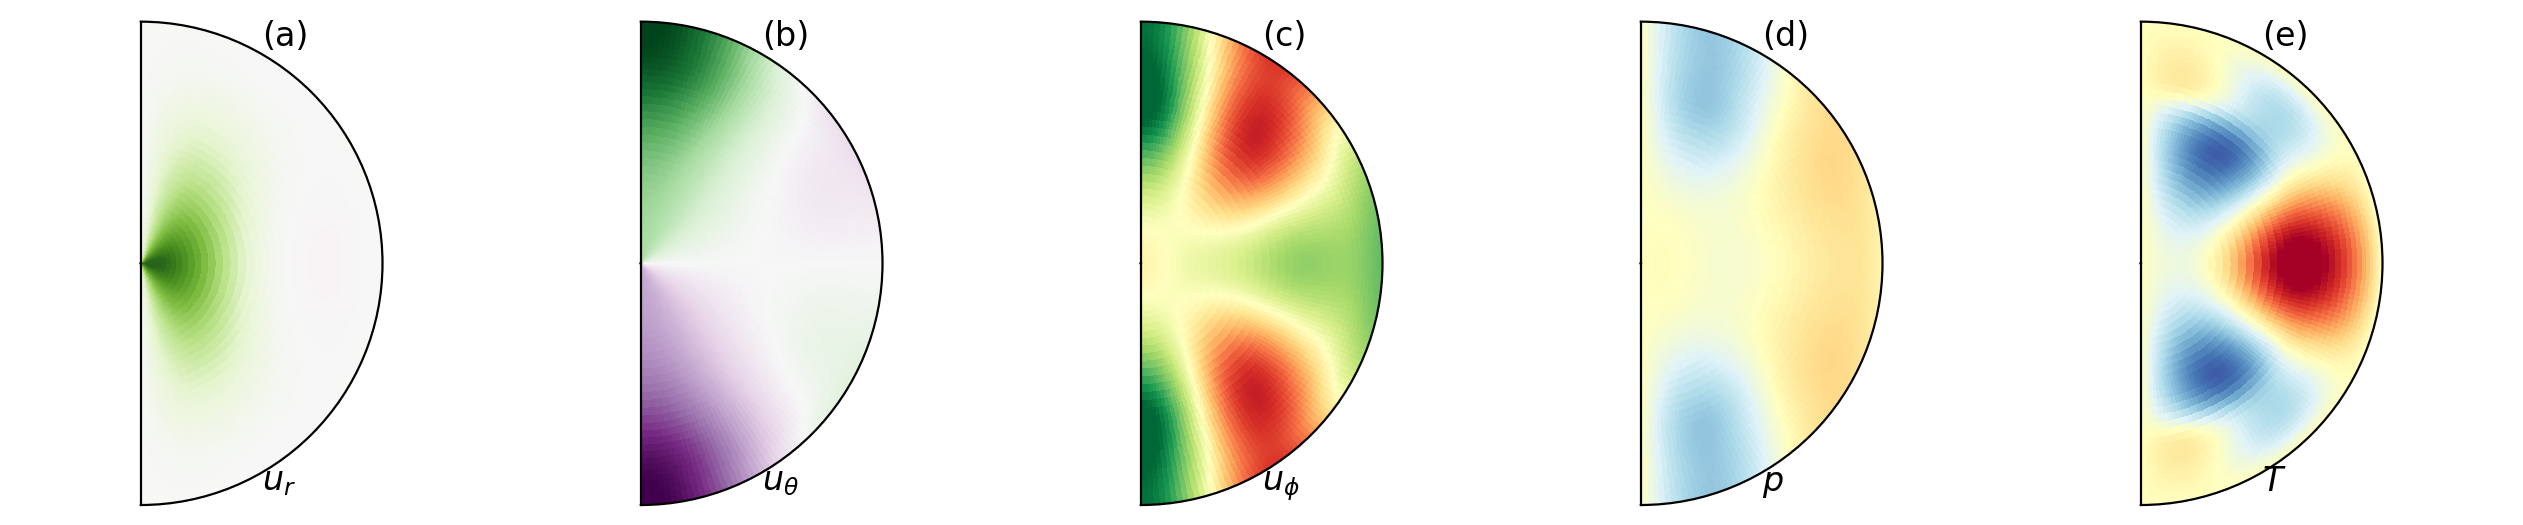

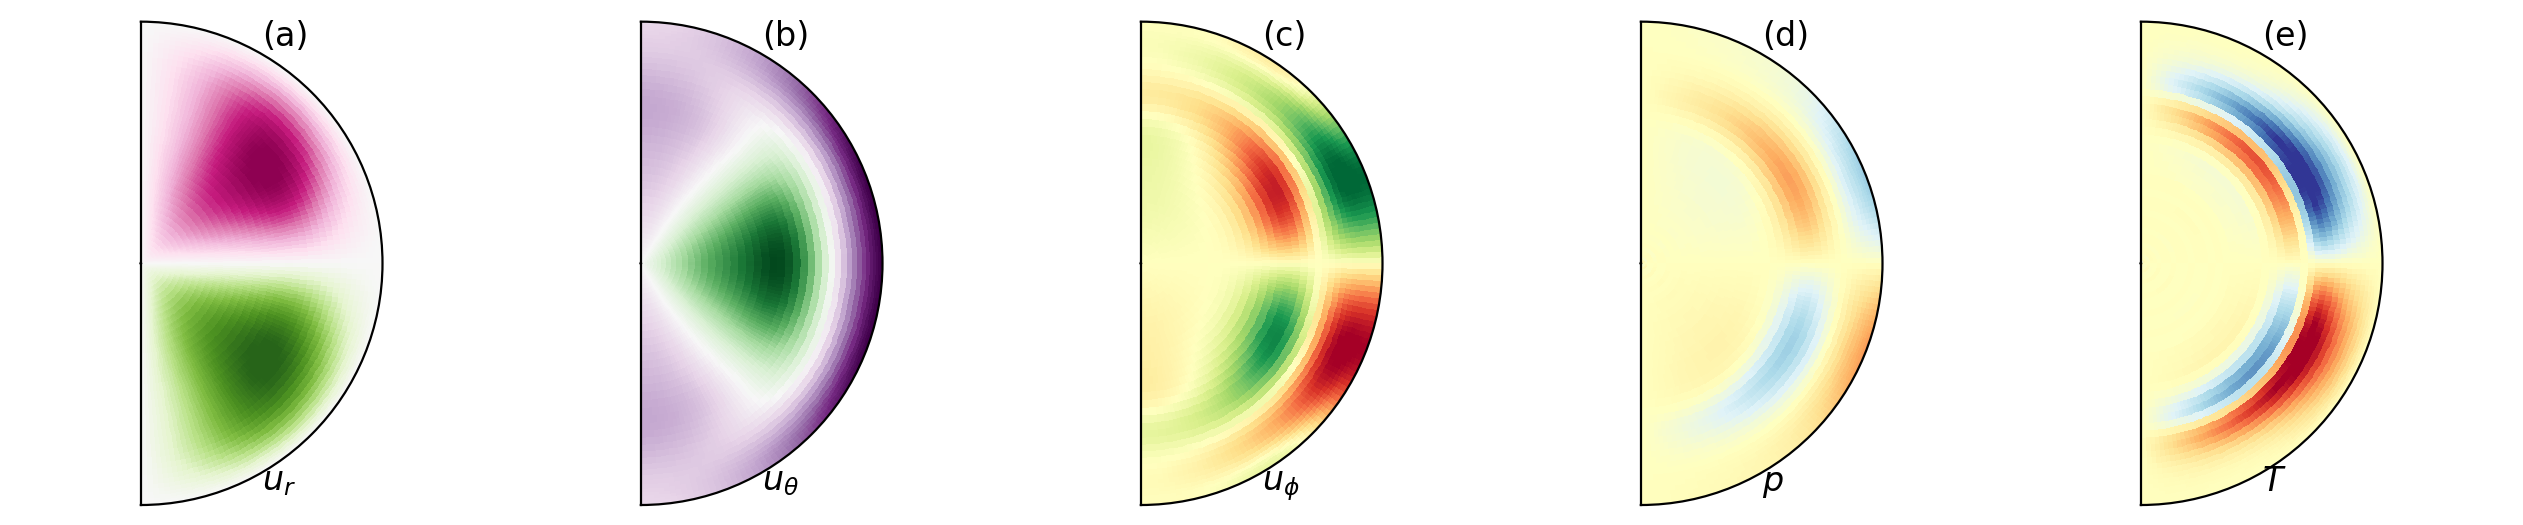

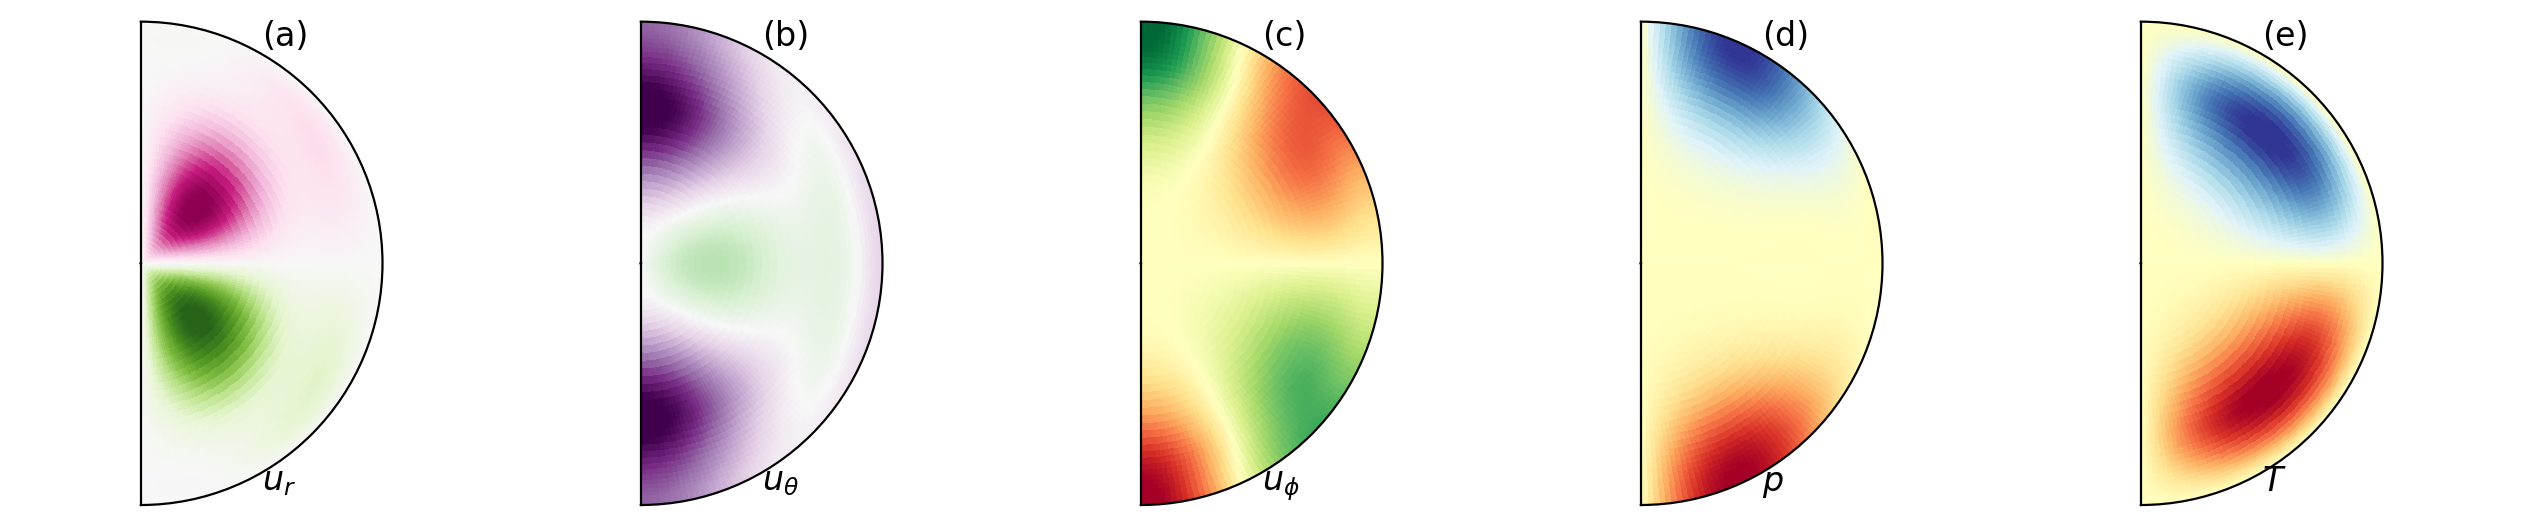

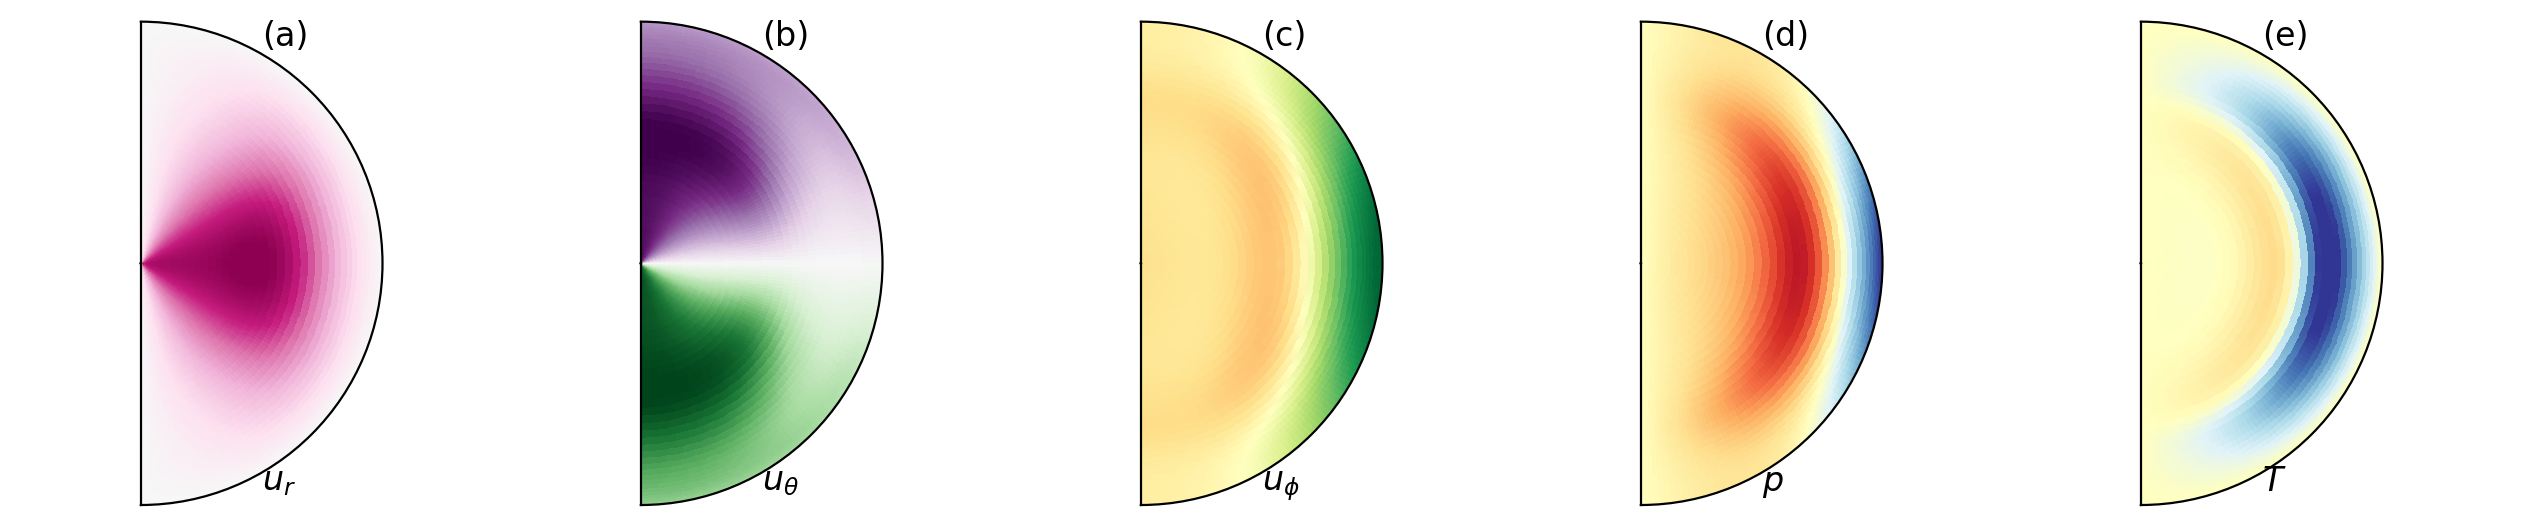

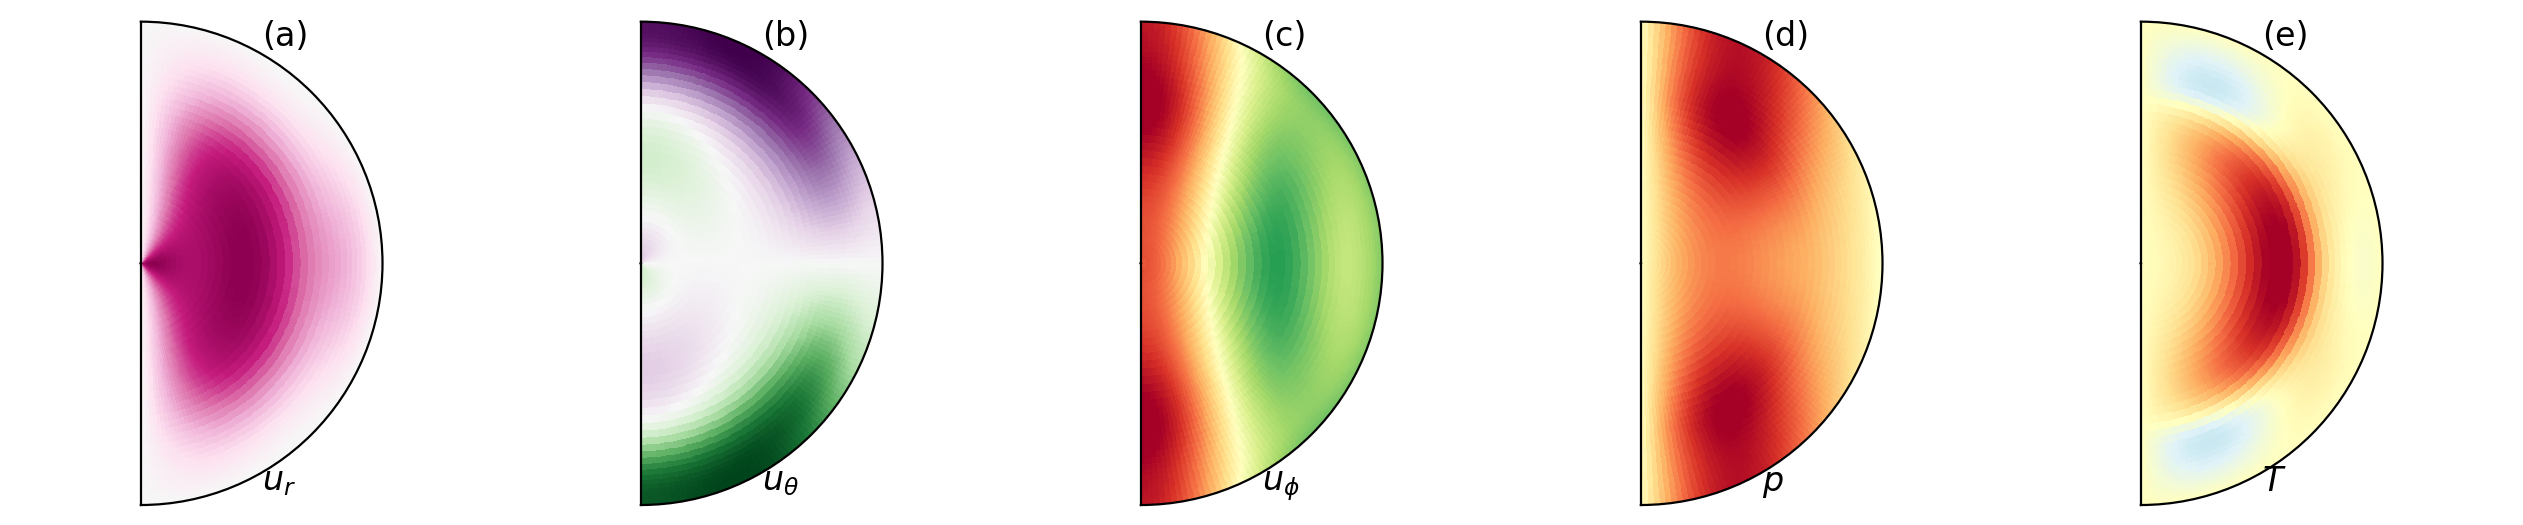

In [14]:
#Find a mode:
idx = np.where((eigs.imag<0.01)&(eigs.imag>-0.05))[0]
idx2 = np.argsort(eigs[idx].imag)
idx = idx[idx2]
print(eigs[idx],idx)
phig, thetag, rg = shell.global_grids((1, 4, 3/2)) #Get local coordinate arrays
thetas = np.array(thetag).flatten()
rads = np.array(rg).flatten()

for jj in idx:
    solver.set_state(jj, ss)
    u.change_scales((1,4,3/2))
    u.require_grid_space()

    p.change_scales((1,4,3/2))
    p.require_grid_space()

    T.change_scales((1,4,3/2))
    T.require_grid_space()
    
    print(np.min(p['g']),np.max(p['g']))
    
    x = thetas
    y = rads
    x = np.pi/2 - x
    xx, yy = np.meshgrid(x, y)

    #fig = plt.figure(figsize=[12.5,5],dpi=200,constrained_layout=False,linewidth=2.0)
    fig, axs = plt.subplots(nrows=1,ncols=5,figsize=[12.5,5],dpi=200,linewidth=2.0,constrained_layout=True,subplot_kw=dict(polar=True))
    data = [u['g'][2][0],u['g'][1][0],u['g'][0][0],p['g'][0],T['g'][0]]
    labels = ['(a)','(b)','(c)','(d)','(e)']
    labels2 = [r'$u_r$',r'$u_\theta$',r'$u_\phi$',r'$p$',r'$T$']
    cmaps = ['PiYG','PRGn','RdYlGn','RdYlBu','RdYlBu']
    saturation = 0.99

    for ii in np.arange(5):
        #x0 = 0.01 + ii*0.2
        #x1 = x0+0.19
        #pos = [x0,0.03,x1,0.94]
        #pb = fig.add_axes(pos,projection='polar')
        axs[ii].set_xticklabels([])
        axs[ii].set_yticklabels([])
    
        field = data[ii].real
        print(np.shape(field))
        vals = np.sort(np.abs(field.flatten()))
        vals = np.sort(vals)
        vmax = vals[int(saturation*len(vals))]
        vmin = -vmax
        print(vmin,vmax)
   
        meplot = axs[ii].pcolormesh(xx, yy, field.T, cmap=cmaps[ii], vmin=vmin, vmax=vmax, rasterized=False, shading='auto')
        #if (ii % 2 ==0):
        #    meplot2 = pb.contour(xx,yy,field.T,16,colors='xkcd:grey')
            
        axs[ii].set_theta_offset(0)
        axs[ii].set_thetalim([-np.pi/2,np.pi/2])
        axs[ii].set_rlim(0.001,1.0)
        axs[ii].set_rorigin(0)
        axs[ii].set_aspect(1)
        axs[ii].grid(False)
        axs[ii].text(0.5,0.95,labels[ii],transform=axs[ii].transAxes,fontsize=12)
        axs[ii].text(0.5,0.03,labels2[ii],transform=axs[ii].transAxes,fontsize=12)
    fig.subplots_adjust(left=0.0,right=1.0)
    fig.savefig('Inertial_Wave_Eigenmode_{:d}'.format(jj)+'.png')